In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [2]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

# Parameters

In [ ]:
grid = (2,2) # grid size
num_train = 20 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

In [4]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/Shortest_Path_Macbook/'+str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_exp=1/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)
DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Macbook/2by2_grid_SPO_Data_Generation_exp=1/


# Generate Data

In [5]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,data_generation_process) 
    # print("W_star = ",W_star[0,:])
    np.random.seed(coef_seed)
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}; noise_train_all = {}; noise_test_all = {}
    for iter in iteration_all:
        DataPath_iter = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_iter).mkdir(parents=True, exist_ok=True)
        W_star = data_gen.generate_truth(DataPath_iter,lower, upper, p, d, iter,data_generation_process) 
        # #  ****** Data generation *********
        x_test_all[iter], c_test_all[iter], x_train_all[iter], c_train_all[iter], noise_train_all[iter],noise_test_all[iter],W_star_all[iter] = data_gen.generate_samples(iter,DataPath_iter,p, d, num_test, num_train, alpha, W_star, mis, num_test, 
                                data_generation_process, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, noise_train_all,noise_test_all,W_star_all

# EPO(SPO+,...)

In [6]:
def Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs):
    W_EPO_all = {}; w0_EPO_all = {}
    cost_EPO_all = {}
    for iter in iteration_all:
        DataPath_seed = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # print("*** seed = ",seed,": Run EPO ******")
        W_EPO_all[iter],w0_EPO_all[iter] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[iter],c_train_all[iter],arcs)
        
        cost_dem = (W_EPO_all[iter] @ x_test_all[iter].T).T + w0_EPO_all[iter]
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            cost_EPO_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_EPO_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])
        print(method_names[0],": iter=",iter,",cost=",np.nanmean(cost_EPO_all[iter]))

    return W_EPO_all,w0_EPO_all,cost_EPO_all

# Obtain DDR estimation

### define network

In [7]:
def _getArcs(grid):
    arcs = []
    for i in range(grid[0]):
        # edges on rows
        for j in range(grid[1] - 1):
            v = i * grid[1] + j
            arcs.append((v, v + 1))
        # edges in columns
        if i == grid[0] - 1:
            continue
        for j in range(grid[1]):
            v = i * grid[1] + j
            arcs.append((v, v + grid[1]))

    arc_index_mapping = {}
    for i in range(len(arcs)):
        arc = arcs[i]
        arc_index_mapping[arc] = i

    return arcs,arc_index_mapping

In [8]:
def solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train):
    
    N,p = x_train.shape
    N,d = c_train.shape

    # DDR
    m = Model("ddr")
    #m.setParam("DualReductions",0)
    m.setParam('OutputFlag', 0)

    W_ind = tuplelist( [(i,j) for i in range(d) for j in range(p)] )
    w0_ind = tuplelist( [i for i in range(d)])

    W_ddr = m.addVars(W_ind, lb=-GRB.INFINITY,name = "W" )
    w0_ddr = m.addVars(w0_ind, lb=-GRB.INFINITY,name = "W0" )
    alpha = m.addVars(N,num_nodes,lb=-GRB.INFINITY,name="alpha")
    expr_obj = 0
    err = []
    for n in range(N):
        cost_true_tem = c_train[n]
        expr_obj = expr_obj + alpha[n,num_nodes-1] - alpha[n,0]
        for ind in range(len(arcs)):
            cost_pred_tem = quicksum([W_ddr[ind,j] * x_train[n,j] for j in range(p)]) + w0_ddr[ind]
            err.append(cost_true_tem[ind] - cost_pred_tem)
            e = arcs[ind]
            j = e[1]
            i = e[0]
            # print("j = ",j,", i = ",i, ", e = ",e)
            m.addConstr(alpha[n,j] - alpha[n,i] >= -mu_fixed*cost_true_tem[ind] - (1-mu_fixed)*cost_pred_tem)

    m.setObjective(quicksum([err[k] * err[k] for k in range(len(err))])/N + lamb*(expr_obj)/N, GRB.MINIMIZE)
    m.optimize()
    
    W_DDR_rst = m.getAttr('x', W_ddr)
    w0_DDR_rst = m.getAttr('x', w0_ddr)
    W_ddr_val = []
    for i in range(d):
        W_ddr_val.append([W_DDR_rst[(i,j)] for j in range(p)])
    w0_ddr_val = [w0_DDR_rst[i] for i in range(d)]

    alpha_rst = m.getAttr('x', alpha)
    return w0_ddr_val,W_ddr_val,alpha_rst,m.ObjVal

# Out-of-sample performance

### Generate data

In [9]:
arcs,arc_index_mapping = _getArcs(grid)
num_arcs = len(arcs)
iteration_all = np.arange(0,100)
# obtain data
x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

# Oracle

In [10]:
from Peformance import performance_evaluation
perfs = performance_evaluation()
cost_Oracle_para_all = {}; cost_Oracle_para_avg = {}
cost_Oracle_realization_all = {}; cost_Oracle_realization_avg = {}

for iter in iteration_all:
    if data_generation_process == "SPO_Data_Generation":
        cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
        cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
        cost_Oracle_para_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter])

    if data_generation_process == "DDR_Data_Generation":
        cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
        cost_oracle_pred = (cost_oracle_ori ** mis).T
        cost_Oracle_para_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter])
        # cost_Oracle_para_avg[iter] = np.nanmean(cost_Oracle_para_all[iter])
    print("Oracle: iter=",iter,",cost_avg=",np.nanmean(cost_Oracle_para_all[iter]))

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 0 ,cost_avg= 7.521533144601641
Oracle: iter= 1 ,cost_avg= 7.444351303669702
Oracle: iter= 2 ,cost_avg= 7.904685376020488
Oracle: iter= 3 ,cost_avg= 7.422847909366657
Oracle: iter= 4 ,cost_avg= 7.4797397249356
Oracle: iter= 5 ,cost_avg= 7.708463468108752
Oracle: iter= 6 ,cost_avg= 7.585535358324262
Oracle: iter= 7 ,cost_avg= 7.678715566938768
Oracle: iter= 8 ,cost_avg= 7.306874193445141
Oracle: iter= 9 ,cost_avg= 7.704565654312079
Oracle: iter= 10 ,cost_avg= 7.680774758369178
Oracle: iter= 11 ,cost_avg= 7.758467488868476
Oracle: iter= 12 ,cost_avg= 7.587478042334291
Oracle: iter= 13 ,cost_avg= 7.841945019306693
Oracle: iter= 14 ,cost_avg= 7.4386723902057
Oracle: iter= 15 ,cost_avg= 7.685978664595026
Oracle: iter= 16 ,cost_avg= 7.564161095966034
Oracle: iter= 17 ,cost_avg= 7.5556221044128
Oracle: iter= 18 ,cost_avg= 7.778834313987996
Oracle: iter= 19 ,cost_avg= 7.546646430119443
Oracl

### EPO performance

In [11]:
# EPO, including SPO, PG, LTR
batch_size = 20
num_epochs = 1000
# method_names = ["spo+","pg","ltr"]
from PYEPO import PyEPO_Method
epo_runner = PyEPO_Method()
from Peformance import performance_evaluation
perfs = performance_evaluation()

method_names = ["spo+"]
W_SPO_all,w0_SPO_all,cost_SPO_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs)

# method_names = ["pg"]
# W_PG_all,w0_PG_all,cost_PG_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
#                   arcs,grid,epo_runner,perfs)

# method_names = ["ltr"]
# W_LTR_all,w0_LTR_all,cost_LTR_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
#                   arcs,grid,epo_runner,perfs)

Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5264.60it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.774670147437088
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4449.72it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 8.00755071592412
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3931.67it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.957789390307837
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 6331.02it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.859977165182821
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3166.95it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.9792891153135335
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4592.47it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 8.026100257884503
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4047.77it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.827839730240492
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 8756.38it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.9721286821311965
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 11428.62it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.701286737430002
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 8616.96it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.882309419051704
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5080.00it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.85119990455231
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5592.78it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.114658568980667
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4872.85it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.934087283332359
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3724.46it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.019849183982954
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3868.21it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.785333483219887
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 7619.08it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 8.025643150901557
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3373.25it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.109086203510879
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5948.52it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.057171030333748
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5248.13it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.991937453879505
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4467.25it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 8.089275140880517
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4966.61it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.161748393491019
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 7761.48it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.144203817286922
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4022.35it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.072761513852823
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4088.02it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.832421445817102
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3446.43it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.914568700604109
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4395.85it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.01170793137136
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3882.00it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 8.153134931264677
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3243.10it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.952231502574993
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3491.62it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.796221057018874
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4583.94it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.9051681441361215
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4617.75it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.894756687303812
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3969.62it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 8.081274456065355
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4013.50it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 7.929612784077993
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4492.13it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.087562367103533
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5844.91it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.72198369959781
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 7578.47it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.937089408964173
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 7325.66it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.807018623373591
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3940.72it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.954026566018744
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 7074.81it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 8.075207903550268
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4361.12it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 8.033421674210054
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5856.33it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.094413257795107
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5034.27it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.8180399384957875
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4558.78it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.87344937005135
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3073.65it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.169248406268945
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4370.43it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.832030749828589
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 6385.48it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.916761659443296
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4529.98it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 8.173899112002019
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5544.72it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.210480768267903
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4326.03it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.848868550836187
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4417.15it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 8.123765012949542
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3376.10it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.471328640365558
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3769.99it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.039466539208895
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3353.97it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.795653417985881
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3832.86it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.9239345638218746
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4758.41it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 8.035731411093582
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3873.04it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.017340657361713
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 6679.89it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.334302814911045
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3469.23it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.127666665981527
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3996.86it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.087614050020708
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4576.69it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.891947141281688
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 6317.20it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 8.009258693941183
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3927.62it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.931760606979459
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4365.66it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.750568645333084
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4765.17it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.024340681376463
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5550.96it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 8.10386856068208
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3435.84it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.85260992539223
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4172.81it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.218384541482497
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3793.52it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.15437599113042
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3764.41it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 8.055287965523908
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4449.48it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 8.051803704405577
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3871.61it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.176182873459359
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4306.49it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.748325077747764
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5622.77it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.67819658118072
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3837.95it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.8742441032058235
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5285.49it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.296843899816752
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 6757.38it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 7.856183870997669
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3810.23it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.246624849906427
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4414.82it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.688269305716325
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4807.50it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.226235066417612
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4536.34it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.392131748420224
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 6949.39it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 8.012809765392438
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3863.94it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.846163018722737
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5480.60it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.97533315039233
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4637.15it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 8.159341927440689
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3947.21it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 8.009505844028492
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5704.21it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.911655878885724
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4657.49it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.914676896172427
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3812.31it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 8.196102772363355
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5069.56it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.106827724818167
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3199.44it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.15642180895089
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4441.47it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.151401519535908
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5811.70it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 8.096543086890057
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 3547.88it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.946421821805705
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 8097.11it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.888308618709284
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 2760.50it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.870035702365686
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4630.75it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.950936763954974
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4923.47it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 8.13813908416631
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4442.41it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.886421692709109
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 4485.41it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 8.00531593982822
Optimizing for optDataset...


100%|██████████| 20/20 [00:00<00:00, 5076.31it/s]

Num of cores: 2
spo+ : iter= 99 ,cost= 8.155143011479424


### OLS performance

In [12]:
from OLS import ols_method
ols_method_obj = ols_method()
W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
cost_OLS_all = {}
for iter in iteration_all:
    # compute OLS performance
    W_ols_all[iter], w0_ols_all[iter], t_ols_all[iter], obj_ols_all[iter] = ols_method_obj.ols_solver("",x_train_all[iter], c_train_all[iter])
    cost_dem = (W_ols_all[iter] @ x_test_all[iter].T).T + w0_ols_all[iter]

    if data_generation_process == "SPO_Data_Generation":
        cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
        cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
        cost_OLS_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])

    if data_generation_process == "DDR_Data_Generation":
        cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
        cost_oracle_pred = (cost_oracle_ori ** mis).T
        cost_OLS_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])
    print("OLS: iter=",iter,",cost_avg ratio =",np.nanmean(cost_OLS_all[iter]))

OLS: iter= 0 ,cost_avg ratio = 7.958804923430456
OLS: iter= 1 ,cost_avg ratio = 7.612786505154947
OLS: iter= 2 ,cost_avg ratio = 7.961706277551044
OLS: iter= 3 ,cost_avg ratio = 7.455448650757344
OLS: iter= 4 ,cost_avg ratio = 7.845201981348276
OLS: iter= 5 ,cost_avg ratio = 7.8411597807195985
OLS: iter= 6 ,cost_avg ratio = 7.855571257775871
OLS: iter= 7 ,cost_avg ratio = 7.751448852897712
OLS: iter= 8 ,cost_avg ratio = 7.390880013886479
OLS: iter= 9 ,cost_avg ratio = 7.806347238972399
OLS: iter= 10 ,cost_avg ratio = 7.987750762826046
OLS: iter= 11 ,cost_avg ratio = 7.777013106930069
OLS: iter= 12 ,cost_avg ratio = 7.671721896241327
OLS: iter= 13 ,cost_avg ratio = 8.123655724563331
OLS: iter= 14 ,cost_avg ratio = 7.484084690672268
OLS: iter= 15 ,cost_avg ratio = 7.696447535792969
OLS: iter= 16 ,cost_avg ratio = 7.610186067132678
OLS: iter= 17 ,cost_avg ratio = 7.859986075794883
OLS: iter= 18 ,cost_avg ratio = 7.932924943689716
OLS: iter= 19 ,cost_avg ratio = 7.8058178601199835
OLS: ite

### DDR performance

In [13]:
def obtain_DDR_out_of_sample_performance(mu_all,lamb_all,num_nodes,x_train,c_train,x_test,noise_test,perfs,grid,W_star,bump,mis):
    lamb_index = 0
    cost_DDR = {}; w0_ddr_dict = {}; W_ddr_dict = {}
    cost_DDR_avg = np.zeros((len(mu_all),len(lamb_all)))
    mu_index = 0
    for mu in mu_all:
        lamb_index = 0
        for lamb in lamb_all:

            w0_ddr_dict[mu,lamb],W_ddr_dict[mu,lamb],alpha_rst,obj_ddr = solve_DDR(arcs,lamb,mu,num_nodes,x_train,c_train)
            cost_dem = (W_ddr_dict[mu,lamb] @ x_test.T).T + w0_ddr_dict[mu,lamb]

            if data_generation_process == "SPO_Data_Generation":
                cost_oracle_ori = (W_star @ x_test.T)/np.sqrt(num_feat) + 3
                cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
                cost_DDR[mu,lamb] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test)

            if data_generation_process == "DDR_Data_Generation":
                cost_oracle_ori = (W_star @ x_test.T) + bump
                cost_oracle_pred = (cost_oracle_ori ** mis).T
                cost_DDR[mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test)

            cost_DDR_avg[mu_index,lamb_index] = np.nanmean(cost_DDR[mu,lamb])
            lamb_index = lamb_index + 1
        # print("cost_DDR_avg=",np.round(cost_DDR_avg[0,:],4))
        mu_index = mu_index + 1
    return cost_DDR,w0_ddr_dict,W_ddr_dict,cost_DDR_avg

In [14]:
def obtain_ddr_rst(iteration_all,mu_all,lamb_all,num_nodes,x_train_all,c_train_all,x_test_all,noise_test_all,perfs,grid,W_star_all,bump,mis):
    cost_DDR_all = {}; w0_ddr_all = {}; W_ddr_all = {}
    cost_DDR_avg_all = {}
    for iter in iteration_all:
        cost_DDR_all[iter],w0_ddr_all[iter],W_ddr_all[iter],cost_DDR_avg_all[iter] = obtain_DDR_out_of_sample_performance(mu_all,lamb_all,num_nodes,x_train_all[iter],c_train_all[iter],x_test_all[iter],noise_test_all[iter],perfs,grid,W_star_all[iter],bump,mis)
        print("DDR iter = ",iter)
    return cost_DDR_all,w0_ddr_all,W_ddr_all,cost_DDR_avg_all

In [15]:
mu_all = np.round(np.arange(0.1,1.0,0.1),4)
lamb_all = np.round(np.arange(0.0,1.0,0.1),4)
cost_DDR_all,w0_ddr_all,W_ddr_all,cost_DDR_avg_all = obtain_ddr_rst(iteration_all,mu_all,lamb_all,num_nodes,x_train_all,c_train_all,x_test_all,noise_test_all,perfs,grid,W_star_all,bump,mis)

DDR iter =  0
DDR iter =  1
DDR iter =  2
DDR iter =  3
DDR iter =  4
DDR iter =  5
DDR iter =  6
DDR iter =  7
DDR iter =  8
DDR iter =  9
DDR iter =  10
DDR iter =  11
DDR iter =  12
DDR iter =  13
DDR iter =  14
DDR iter =  15
DDR iter =  16
DDR iter =  17
DDR iter =  18
DDR iter =  19
DDR iter =  20
DDR iter =  21
DDR iter =  22
DDR iter =  23
DDR iter =  24
DDR iter =  25
DDR iter =  26
DDR iter =  27
DDR iter =  28
DDR iter =  29
DDR iter =  30
DDR iter =  31
DDR iter =  32
DDR iter =  33
DDR iter =  34
DDR iter =  35
DDR iter =  36
DDR iter =  37
DDR iter =  38
DDR iter =  39
DDR iter =  40
DDR iter =  41
DDR iter =  42
DDR iter =  43
DDR iter =  44
DDR iter =  45
DDR iter =  46
DDR iter =  47
DDR iter =  48
DDR iter =  49
DDR iter =  50
DDR iter =  51
DDR iter =  52
DDR iter =  53
DDR iter =  54
DDR iter =  55
DDR iter =  56
DDR iter =  57
DDR iter =  58
DDR iter =  59
DDR iter =  60
DDR iter =  61
DDR iter =  62
DDR iter =  63
DDR iter =  64
DDR iter =  65
DDR iter =  66
DDR i

In [16]:
regret_ddr_vs_ols_para_all = {}; regret_ddr_vs_ols_para_avg = np.zeros((len(mu_all),len(lamb_all)))

regret_spo_vs_ols_para_all = {}; regret_spo_vs_ols_para_avg = 0


cost_OLS_avg_all = np.zeros(len(iteration_all))
cost_Oracle_para_avg_all = np.zeros(len(iteration_all))
cost_Oracle_realization_avg_all = np.zeros(len(iteration_all))

for iter_index in range(len(iteration_all)):
    iter = iteration_all[iter_index]
    cost_OLS_avg_all[iter_index] = np.nanmean(cost_OLS_all[iter])
    cost_Oracle_para_avg_all[iter_index] = np.nanmean(cost_Oracle_para_all[iter])

    regret_ddr_vs_ols_para_all[iter_index] = (cost_OLS_avg_all[iter_index] - cost_DDR_avg_all[iter])/np.abs(cost_OLS_avg_all[iter_index] - cost_Oracle_para_avg_all[iter_index])
    regret_ddr_vs_ols_para_avg = regret_ddr_vs_ols_para_avg + regret_ddr_vs_ols_para_all[iter_index]

    regret_spo_vs_ols_para_all[iter] = (cost_OLS_avg_all[iter_index] - np.nanmean(cost_SPO_all[iter]))/np.abs(cost_OLS_avg_all[iter_index] - cost_Oracle_para_avg_all[iter_index])
    regret_spo_vs_ols_para_avg = regret_spo_vs_ols_para_avg + regret_spo_vs_ols_para_all[iter]

regret_ddr_vs_ols_para_avg = regret_ddr_vs_ols_para_avg/len(iteration_all)
regret_spo_vs_ols_para_avg = regret_spo_vs_ols_para_avg/len(iteration_all)

regret_DDR_vs_OLS_para_avg_df = pd.DataFrame(regret_ddr_vs_ols_para_avg)
regret_DDR_vs_OLS_para_avg_df.index = ["$\mu="+str(mu)+"$" for mu in mu_all]
regret_DDR_vs_OLS_para_avg_df.columns = ["$\lambda="+str(lamb)+"$" for lamb in lamb_all]
regret_DDR_vs_OLS_para_avg_df.to_csv(DataPath+"regret_DDR_vs_OLS_para_avg.csv")

In [17]:
cost_OLS_avg_all

array([7.95880492, 7.61278651, 7.96170628, 7.45544865, 7.84520198,
       7.84115978, 7.85557126, 7.75144885, 7.39088001, 7.80634724,
       7.98775076, 7.77701311, 7.6717219 , 8.12365572, 7.48408469,
       7.69644754, 7.61018607, 7.85998608, 7.93292494, 7.80581786,
       8.16610141, 7.8391981 , 7.78979396, 8.06195804, 7.8259751 ,
       7.99120486, 7.82156889, 7.89268335, 7.62373822, 7.77961635,
       7.84577181, 7.5804046 , 7.9081262 , 7.8681075 , 7.88458173,
       7.78878096, 7.49302657, 7.55426166, 7.71025818, 7.60416674,
       8.06029295, 7.63679451, 7.66182949, 7.79875723, 7.64208629,
       7.68591439, 7.96033344, 7.76095591, 7.81604417, 7.85659001,
       7.56488264, 8.02865254, 7.81700127, 7.78201271, 7.5960527 ,
       7.8949132 , 7.56579931, 7.99326088, 7.87228072, 7.78040944,
       7.86088901, 7.71164723, 7.79475158, 7.90936455, 7.79923262,
       7.64594141, 8.18887615, 7.7035232 , 7.68361796, 7.58357807,
       7.77742048, 7.73615974, 7.71227158, 7.84336804, 7.80491

In [18]:
with open(DataPath+'cost_OLS_all.pkl', "wb") as tf:
    pickle.dump(cost_OLS_all,tf)
with open(DataPath+'cost_Oracle_para_all.pkl', "wb") as tf:
    pickle.dump(cost_Oracle_para_all,tf)
with open(DataPath+'cost_DDR_all.pkl', "wb") as tf:
    pickle.dump(cost_DDR_all,tf)
with open(DataPath+'cost_SPO_all.pkl', "wb") as tf:
    pickle.dump(cost_SPO_all,tf)

# Plot figures

In [19]:
def cross_compare2plus(c_item, c_base, c_oracle):
    c_item = np.asarray(c_item)
    c_base = np.asarray(c_base)
    c_oracle = np.asarray(c_oracle)

    N = len(c_item)
    c_diff = c_item - c_base
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff < 0)
    lose = np.sum(c_diff > 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
    # print("Num_train =",N,",Num_equals =",equals,",Num_wins =",wins,",Num_lose =",lose)
    # print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    # cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
    regret_reduction = (np.nanmean(c_base) - np.nanmean(c_item))/np.abs(np.nanmean(c_base) - np.nanmean(c_oracle))
    return lbel, win_ratio, regret_reduction

### DDR figure

In [20]:
# H2H_DDR_vs_OLS_all = {}; regret_reduction_DDR_vs_OLS_all = {}
# for mu in mu_all:
#     for lamb in lamb_all:
#         H2H_DDR_vs_OLS_arr = np.zeros(len(iteration_all)); regret_reduction_DDR_vs_OLS_arr = np.zeros(len(iteration_all))
#         # print("lamb = ",lamb)
#         iter_index = 0
#         for iter in iteration_all:
#             lbel, H2H_DDR_vs_OLS_arr[iter_index], regret_reduction_DDR_vs_OLS_arr[iter_index] = cross_compare2plus(cost_DDR_all[iter][mu,lamb],cost_OLS_all[iter], cost_Oracle_para_avg_all[iter])
#             iter_index = iter_index + 1
#         H2H_DDR_vs_OLS_all[mu,lamb] = H2H_DDR_vs_OLS_arr; regret_reduction_DDR_vs_OLS_all[mu,lamb] = regret_reduction_DDR_vs_OLS_arr

In [21]:
# mu = mu_all[4]
# lamb = lamb_all[6]
# import Figures
# file_name = DataPath + "figure_mu="+str(mu)+"_lamb="+str(lamb)
# Figures.figure_plot_upleft(H2H_DDR_vs_OLS_all[mu,lamb]*100, regret_reduction_DDR_vs_OLS_all[mu,lamb]*100, file_name, size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
#                     ysame = 0, yrange = [6,6], sublabel = '', ypio = 1)

### SPO figure

In [22]:
H2H_SPO_vs_OLS_all = np.zeros(len(iteration_all)); regret_reduction_SPO_vs_OLS_all = np.zeros(len(iteration_all))
iter_index = 0
for iter in iteration_all:
    # regret_SPO_OLS = (np.nanmean(cost_OLS_all[iter]) - np.nanmean(cost_SPO_all[iter]))/np.abs(np.nanmean(cost_OLS_all[iter_index]) - np.nanmean(cost_Oracle_para_all[iter]))
    # print("iter=",iter,",SPO cost Ratio = ",np.nanmean(cost_SPO_all[iter])/np.nanmean(cost_Oracle_para_all[iter]),",regret=",regret_SPO_OLS)
    lbel, H2H_SPO_vs_OLS_all[iter_index], regret_reduction_SPO_vs_OLS_all[iter_index] = cross_compare2plus(cost_SPO_all[iter],cost_OLS_all[iter], cost_Oracle_para_avg_all[iter])
    iter_index = iter_index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Macbook/2by2_grid_SPO_Data_Generation_exp=1/data_size=20_deg=1.0_e=0.5_d=4_x_dist=uniform_num_test=1000_diff_W/regret_SPO_vs_OLS_SPO_Data_Generation_grid_2by2.pdf


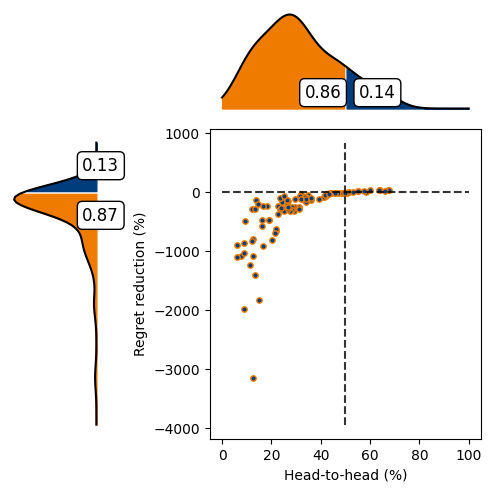

In [23]:
import Figures
file_name = DataPath+"regret_SPO_vs_OLS_"+data_generation_process+"_grid_"+str(grid[0])+"by"+str(grid[1])
Figures.figure_plot_upleft(H2H_SPO_vs_OLS_all*100, regret_reduction_SPO_vs_OLS_all*100, file_name, size = (5, 5), move = [-0.12, 0.04, 0.35, 0.55], 
                    ysame = 0, yrange = [6,6], sublabel = '', ypio = 1)

In [24]:
# regret_reduction_SPO_vs_OLS_arr

In [25]:
cost_avg_ddr_ratio = np.zeros((len(mu_all),len(lamb_all)))
for iter in iteration_all:
    cost_avg_ddr_ratio += cost_DDR_avg_all[iter]/cost_OLS_avg_all[iter]
cost_avg_ddr_ratio = cost_avg_ddr_ratio/len(iteration_all)

In [26]:
np.round((cost_avg_ddr_ratio -1)*100,4)

array([[ 0.    ,  0.0031,  0.013 ,  0.0215,  0.0294,  0.0394,  0.0598,
         0.0775,  0.0941,  0.1043],
       [ 0.    ,  0.0071,  0.0187,  0.0245,  0.0399,  0.0527,  0.0662,
         0.0732,  0.0774,  0.0905],
       [ 0.    ,  0.0017,  0.0101,  0.0166,  0.025 ,  0.0363,  0.0405,
         0.0453,  0.0559,  0.0664],
       [ 0.    ,  0.0018,  0.005 ,  0.0163,  0.0229,  0.03  ,  0.0401,
         0.0454,  0.0517,  0.0583],
       [ 0.    ,  0.0027,  0.003 ,  0.0079,  0.0167,  0.0236,  0.0314,
         0.0378,  0.0366,  0.0407],
       [ 0.    ,  0.    , -0.0017, -0.0013,  0.0039,  0.0054,  0.0057,
         0.008 ,  0.0113,  0.0151],
       [ 0.    , -0.0008,  0.0002,  0.0019,  0.0014,  0.0048,  0.0079,
         0.007 ,  0.0068,  0.0096],
       [ 0.    ,  0.0005,  0.002 ,  0.0019,  0.0026,  0.0036,  0.0037,
         0.0052,  0.0057,  0.0074],
       [ 0.    , -0.0003, -0.0005, -0.0005,  0.0013,  0.0017,  0.0018,
         0.0032,  0.0031,  0.0037]])

In [27]:
np.nanmean(cost_avg_ddr_ratio)

np.float64(1.0001992267382203)

In [28]:
cost_OLS_avg_all

array([7.95880492, 7.61278651, 7.96170628, 7.45544865, 7.84520198,
       7.84115978, 7.85557126, 7.75144885, 7.39088001, 7.80634724,
       7.98775076, 7.77701311, 7.6717219 , 8.12365572, 7.48408469,
       7.69644754, 7.61018607, 7.85998608, 7.93292494, 7.80581786,
       8.16610141, 7.8391981 , 7.78979396, 8.06195804, 7.8259751 ,
       7.99120486, 7.82156889, 7.89268335, 7.62373822, 7.77961635,
       7.84577181, 7.5804046 , 7.9081262 , 7.8681075 , 7.88458173,
       7.78878096, 7.49302657, 7.55426166, 7.71025818, 7.60416674,
       8.06029295, 7.63679451, 7.66182949, 7.79875723, 7.64208629,
       7.68591439, 7.96033344, 7.76095591, 7.81604417, 7.85659001,
       7.56488264, 8.02865254, 7.81700127, 7.78201271, 7.5960527 ,
       7.8949132 , 7.56579931, 7.99326088, 7.87228072, 7.78040944,
       7.86088901, 7.71164723, 7.79475158, 7.90936455, 7.79923262,
       7.64594141, 8.18887615, 7.7035232 , 7.68361796, 7.58357807,
       7.77742048, 7.73615974, 7.71227158, 7.84336804, 7.80491